In [53]:

import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

# Importations depuis transformers
from transformers import TFBertModel, BertTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Initialisation du tokenizer et du modèle BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [56]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [57]:
train = pd.concat([train, valid]).reset_index(drop=True)
#train  = train.sample(frac=0.5, random_state=42).reset_index(drop=True)


In [58]:
train.shape

(13784, 2)

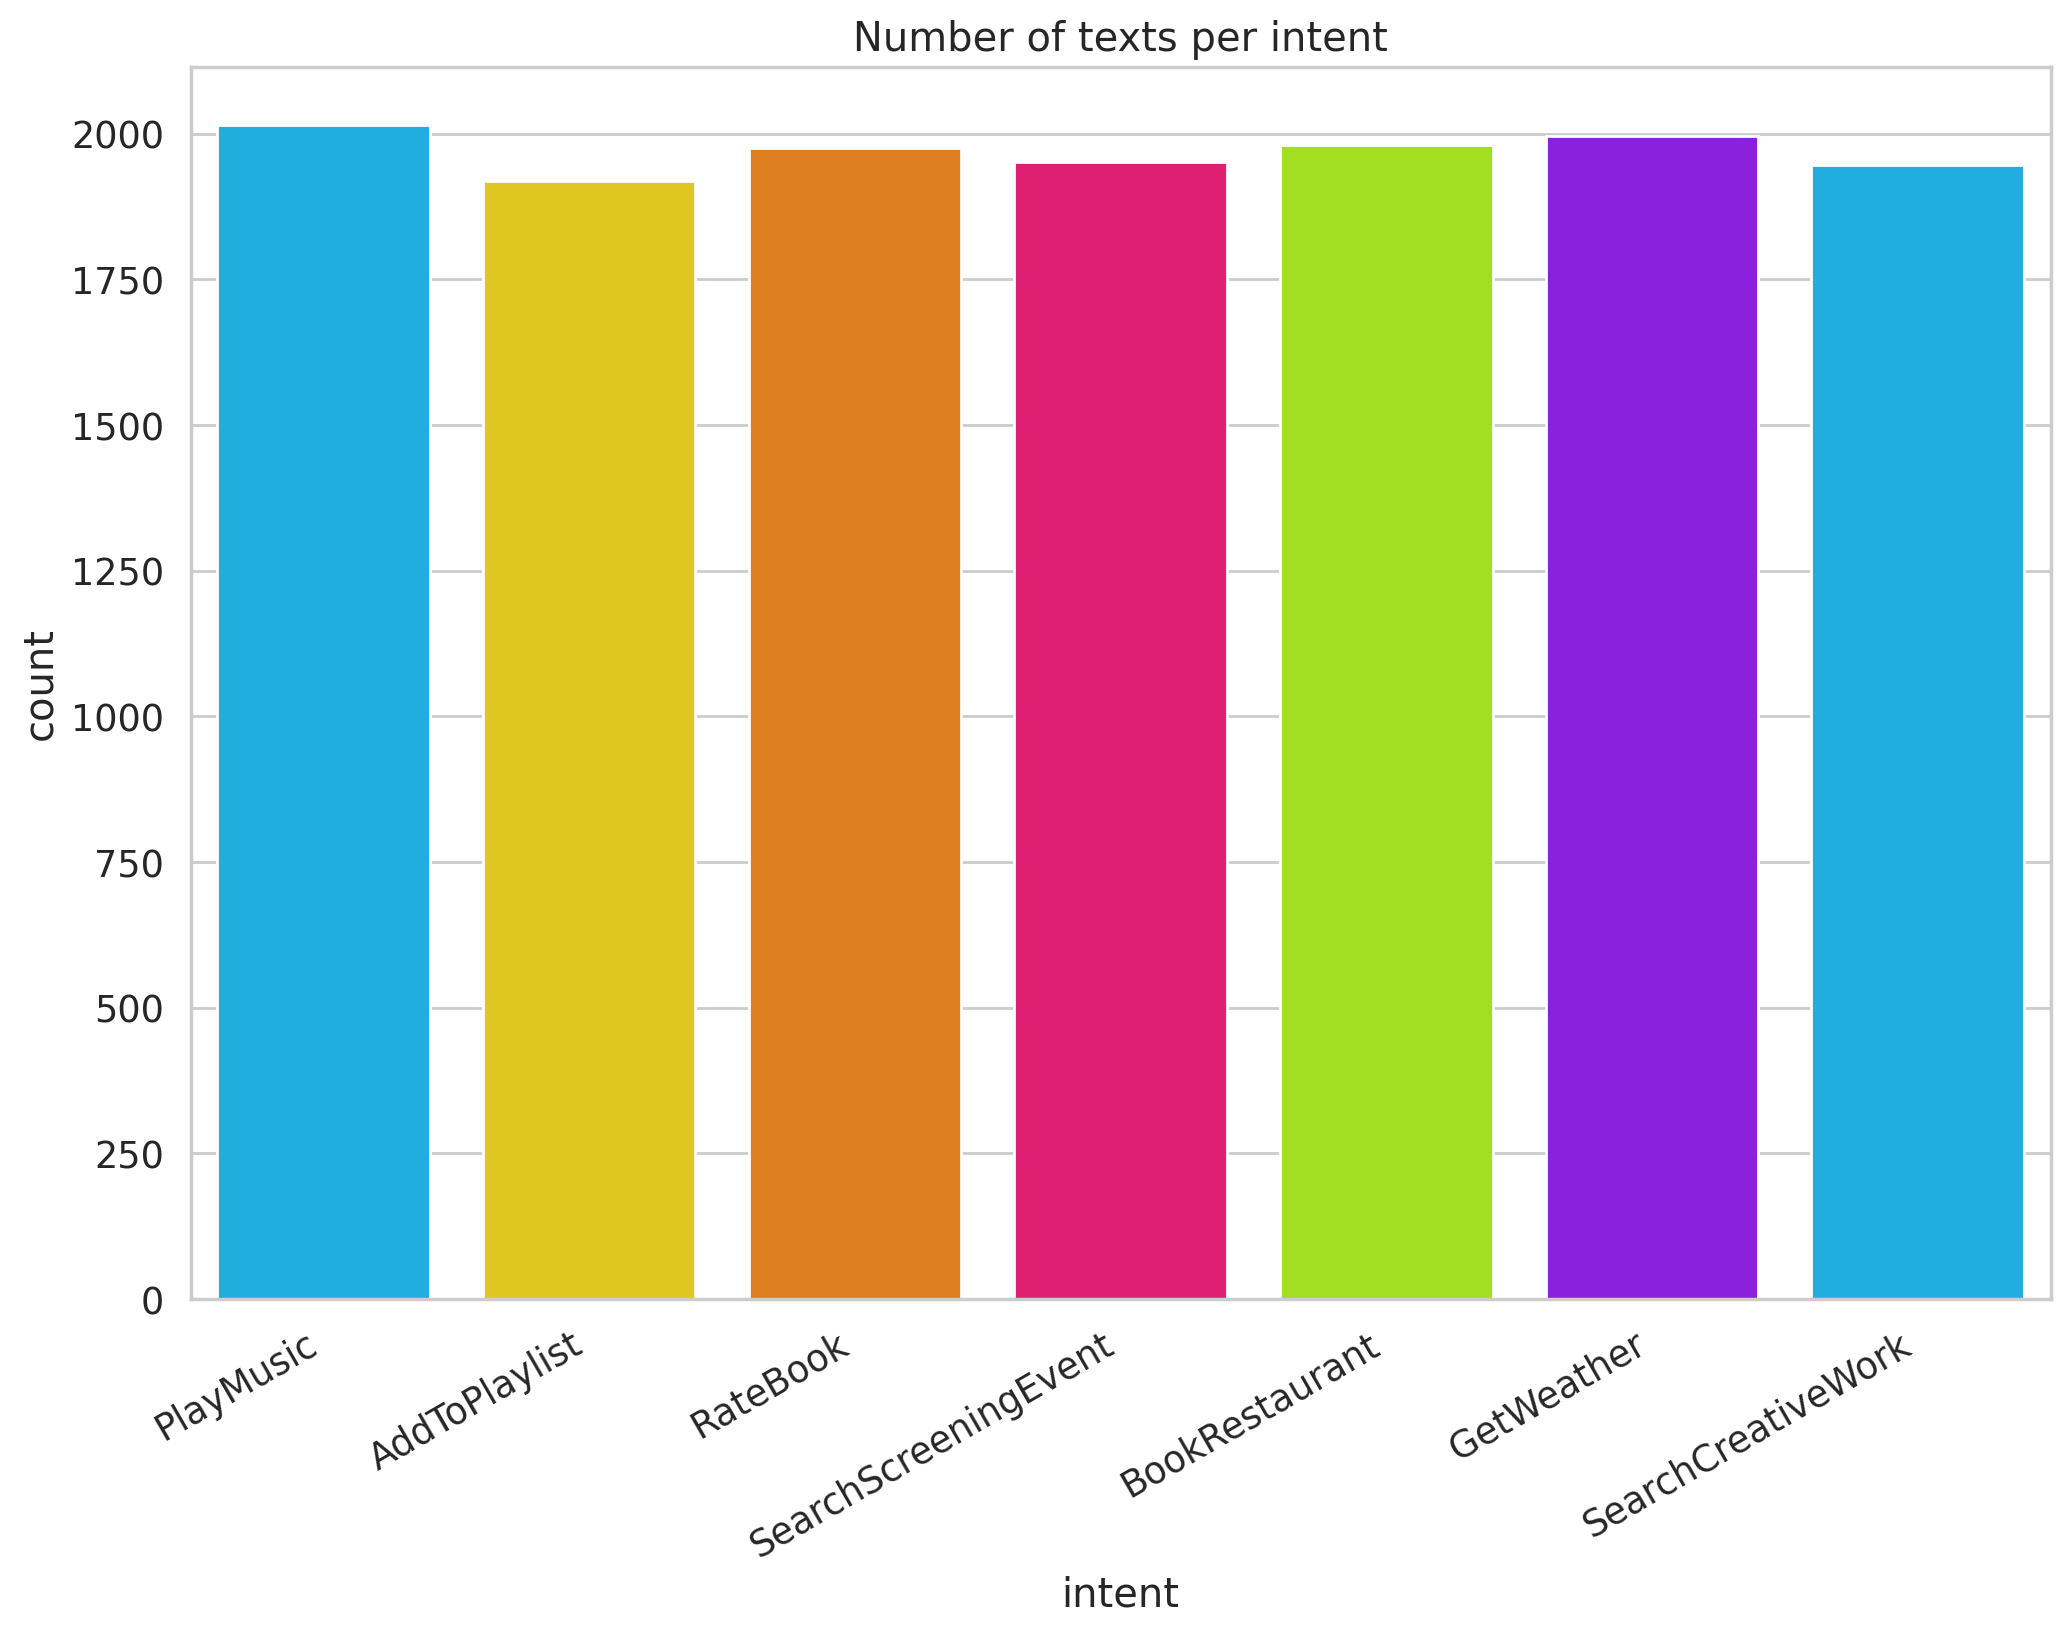

In [59]:
chart = sns.countplot(x="intent", data=train, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()


In [60]:
from transformers import TFBertModel, BertTokenizer

# Initialisation du tokenizer et du modèle BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Déverrouiller les couches BERT pour qu'elles soient entraînables
for layer in bert_model.layers:
    layer.trainable = True

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
class IntentDetectionData:
    DATA_COLUMN = "text"
    LABEL_COLUMN = "intent"

    def __init__(self, train, test, tokenizer, classes, max_seq_len=128):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.classes = classes

        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    def _prepare(self, df):
        x, y = [], []

        for _, row in tqdm(df.iterrows(), total=len(df)):
            text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]

            encoding = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,  
                max_length=self.max_seq_len,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='np'
            )

            x.append(encoding['input_ids'].flatten())
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)


In [62]:
tokenizer.tokenize("I don't want to eat eggs!")

['i', 'don', "'", 't', 'want', 'to', 'eat', 'eggs', '!']

In [63]:
tokens = tokenizer.tokenize("I don't want to eat eggs!")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2123, 1005, 1056, 2215, 2000, 4521, 6763, 999]

In [ ]:


def create_model(max_seq_len, num_classes):
    input_ids = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_ids")
    attention_mask = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="attention_mask")

    # Obtenir les embeddings BERT 
    bert_output = keras.layers.Lambda(
        lambda inputs: bert_model(input_ids=inputs[0], attention_mask=inputs[1])[0],
        output_shape=(max_seq_len, 768)
    )([input_ids, attention_mask])

    # Sélection de la sortie [CLS] pour la classification
    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :], output_shape=(768,))(bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)

    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=num_classes, activation="softmax")(logits)

    model = keras.Model(inputs=[input_ids, attention_mask], outputs=logits)

    return model



classes = sorted(train["intent"].unique().tolist())

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

100%|██████████| 700/700 [00:00<00:00, 1366.04it/s]


In [65]:
data.train_x[0]

array([  101,  4952,  2000,  2225,  3676,  2213,  2632, 25438, 27395,
        2006,  8224,  2189,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [66]:
data.max_seq_len

128

In [ ]:
model = create_model(max_seq_len=data.max_seq_len, num_classes=len(data.classes))


In [68]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 768)       │          0 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 768)       │          0 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 768)       │    590,592 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 768)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 7)         │      5,383 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 595,975 (2.27 MB)

 Trainable params: 595,975 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
from tensorflow.keras.callbacks import TensorBoard

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Chemin pour sauvegarder les logs de TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Définir le callback de TensorBoard
tensorboard_callback = TensorBoard(log_dir=log_dir, update_freq='batch', write_graph=False)

# Création des masques d'attention pour les données d'entraînement
attention_masks = np.where(data.train_x != 0, 1, 0)

# Entraînement du modèle
history = model.fit(
    x={'input_ids': data.train_x, 'attention_mask': attention_masks},
    y=data.train_y,
    validation_split=0.1,
    batch_size=16,
    shuffle=True,
    epochs=20,
   # callbacks=[tensorboard_callback]
)


import os

# Vérifier si le dossier existe, sinon le créer
save_dir = "/kaggle/working/modeles"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Sauvegarder le modèle
model.save(os.path.join(save_dir, "mon_modele.keras"))


Epoch 1/20


W0000 00:00:1730573567.895693      94 assert_op.cc:38] Ignoring Assert operator functional_3_1/lambda_2_1/tf_bert_model_5/bert/embeddings/assert_less/Assert/Assert


775/776 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3731 - loss: 1.6850

W0000 00:00:1730573623.108204      94 assert_op.cc:38] Ignoring Assert operator functional_3_1/lambda_2_1/tf_bert_model_5/bert/embeddings/assert_less/Assert/Assert


776/776 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3733 - loss: 1.6845

W0000 00:00:1730573633.571856      95 assert_op.cc:38] Ignoring Assert operator functional_3_1/lambda_2_1/tf_bert_model_5/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1730573640.684243      95 assert_op.cc:38] Ignoring Assert operator functional_3_1/lambda_2_1/tf_bert_model_5/bert/embeddings/assert_less/Assert/Assert


776/776 ━━━━━━━━━━━━━━━━━━━━ 91s 86ms/step - accuracy: 0.3736 - loss: 1.6840 - val_accuracy: 0.8956 - val_loss: 0.5544
Epoch 2/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.7851 - loss: 0.7103 - val_accuracy: 0.9239 - val_loss: 0.3395
Epoch 3/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.8651 - loss: 0.4659 - val_accuracy: 0.9362 - val_loss: 0.2546
Epoch 4/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.8990 - loss: 0.3572 - val_accuracy: 0.9420 - val_loss: 0.2132
Epoch 5/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.9065 - loss: 0.3128 - val_accuracy: 0.9507 - val_loss: 0.1891
Epoch 6/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.9159 - loss: 0.2757 - val_accuracy: 0.9579 - val_loss: 0.1691
Epoch 7/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.9279 - loss: 0.2451 - val_accuracy: 0.9587 - val_loss: 0.1589
Epoch 8/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.9263 - loss: 0.2361 - val_accurac

In [70]:
import os
import shutil
# Lister les fichiers dans le répertoire pour vérifier la sauvegarde
print(os.listdir("/kaggle/working/modeles"))




['mon_modele.keras']


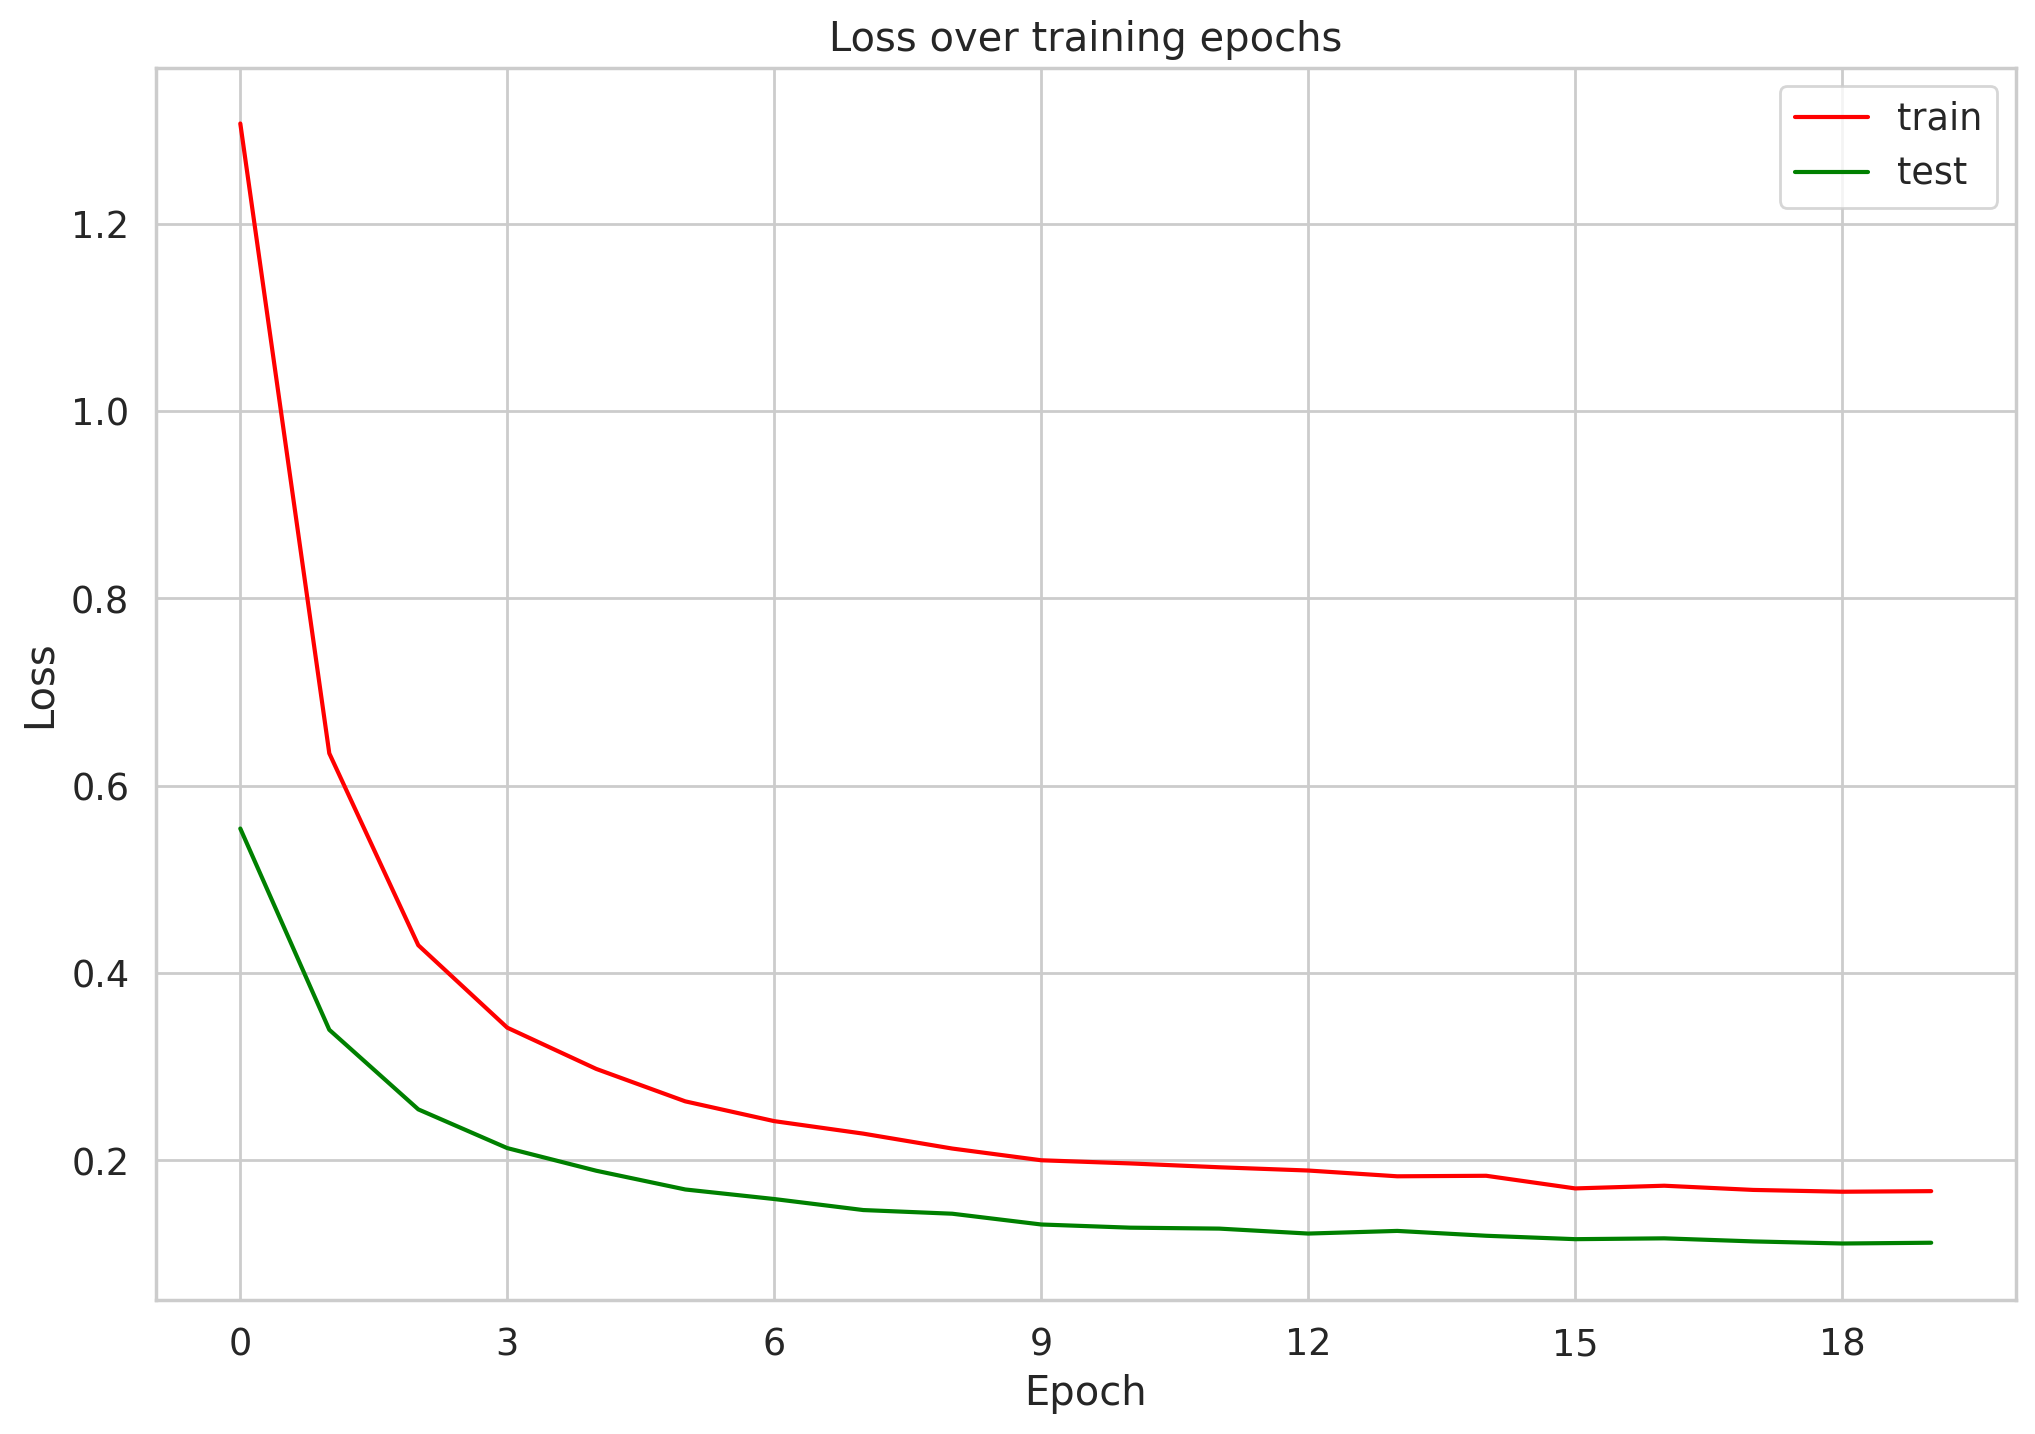

In [ ]:

# Créer la figure et configurer l'axe
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'], color='red')  
ax.plot(history.history['val_loss'], color='green')  

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show()

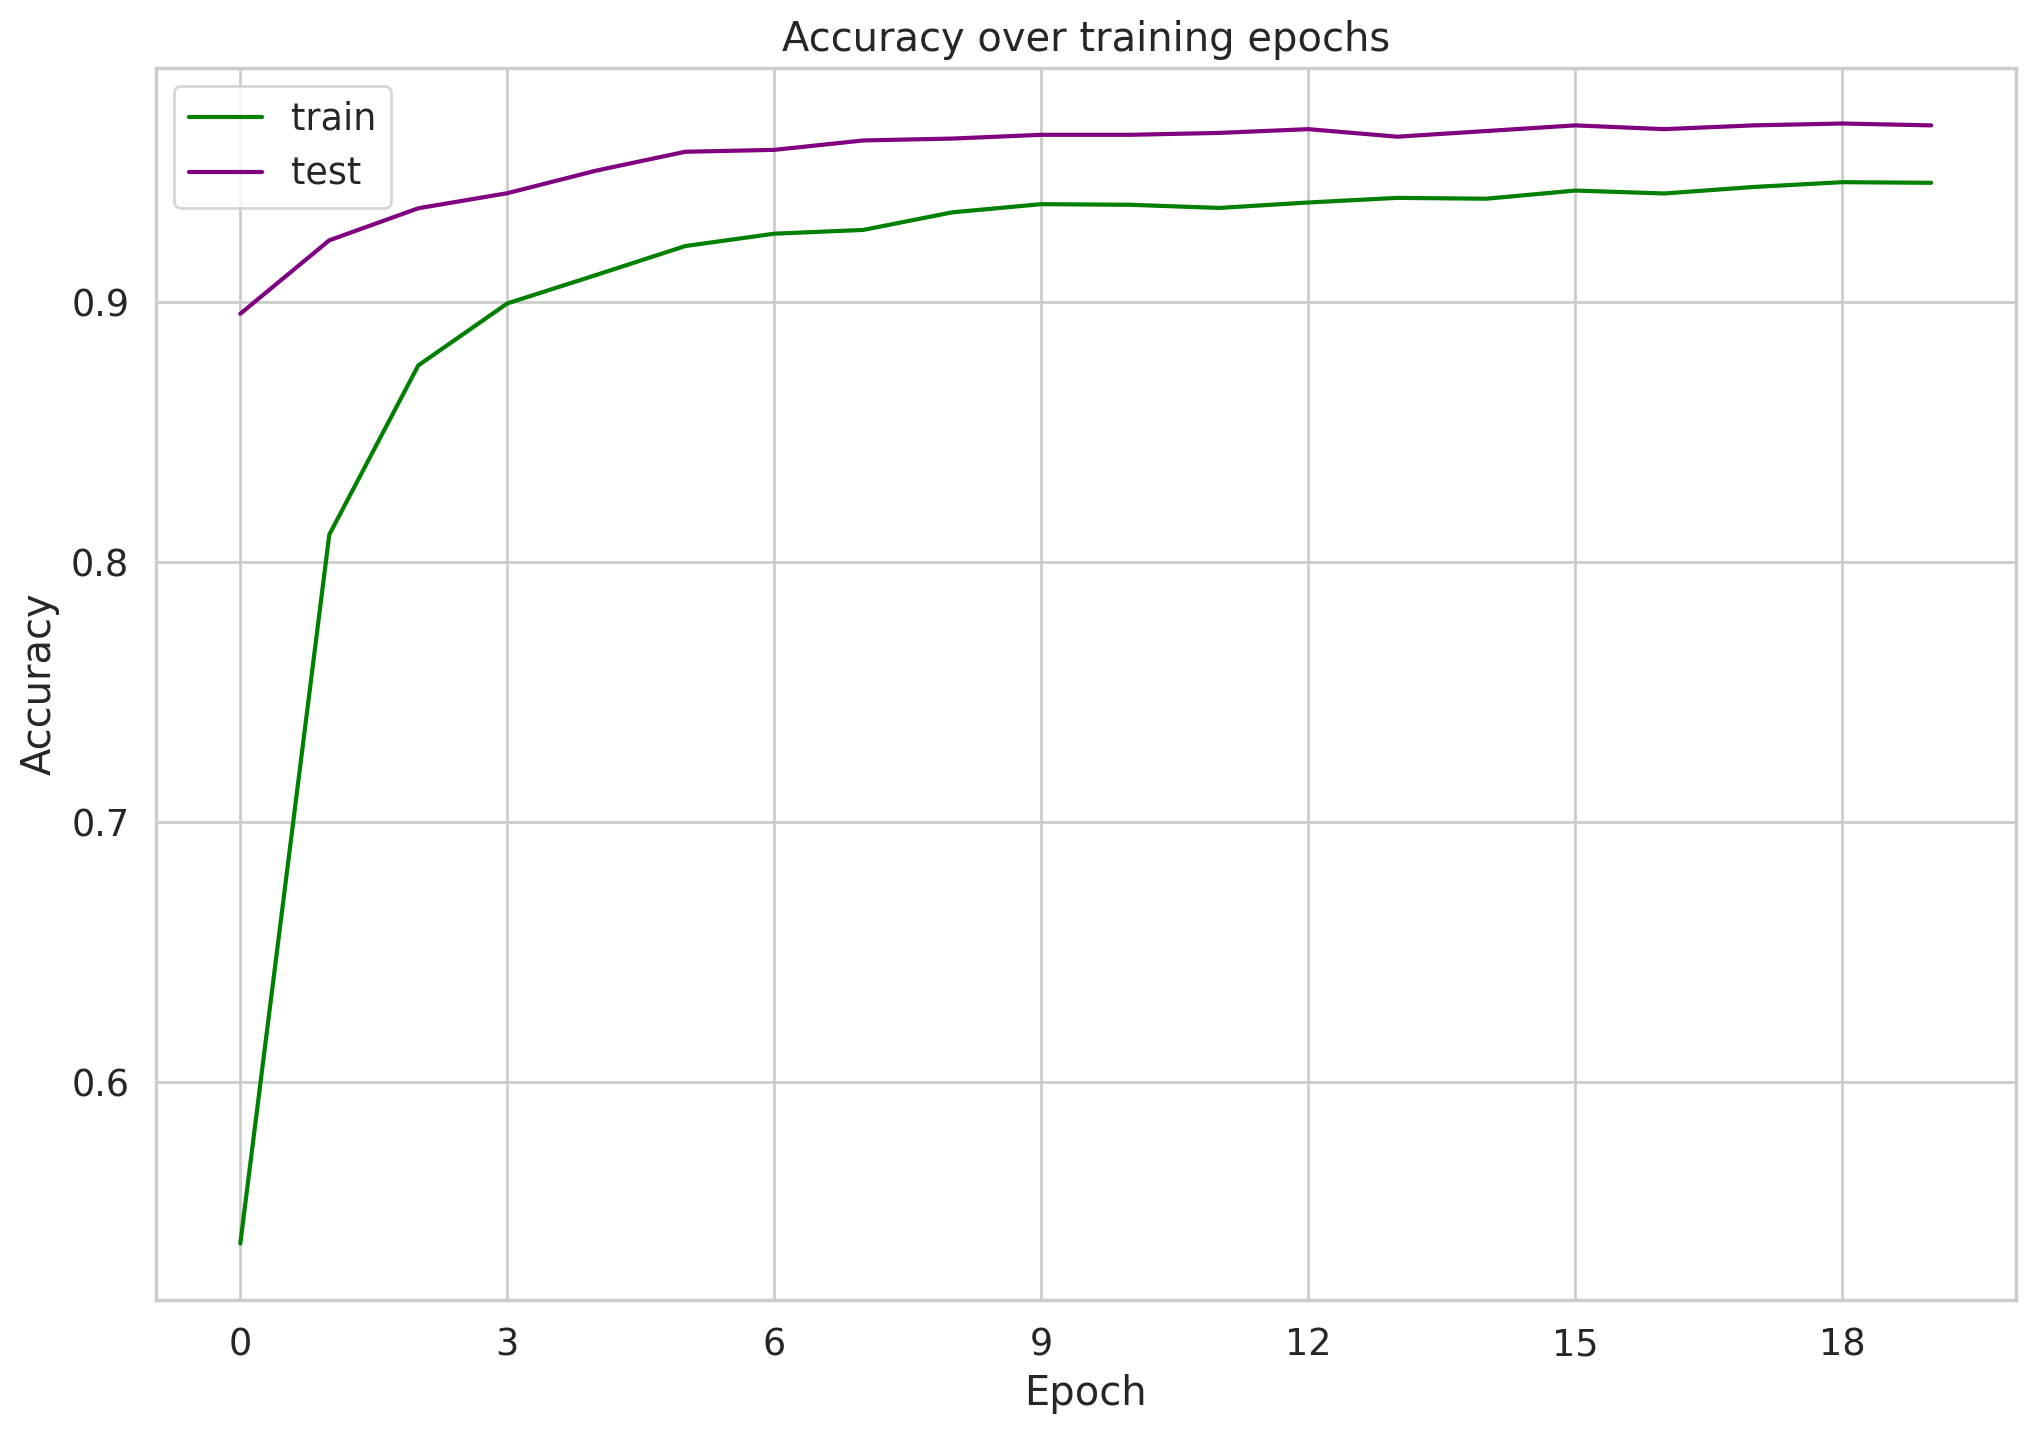

In [ ]:

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['accuracy'], color='green')    
ax.plot(history.history['val_accuracy'], color='purple') 

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show()

In [ ]:
train_input_ids = data.train_x 
train_attention_mask = (train_input_ids != 0).astype(int)  

test_input_ids = data.test_x  
test_attention_mask = (test_input_ids != 0).astype(int) 

train_loss, train_acc = model.evaluate([train_input_ids, train_attention_mask], data.train_y)
test_loss, test_acc = model.evaluate([test_input_ids, test_attention_mask], data.test_y)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)


W0000 00:00:1730574664.048037      95 assert_op.cc:38] Ignoring Assert operator functional_3_1/lambda_2_1/tf_bert_model_5/bert/embeddings/assert_less/Assert/Assert


430/431 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9748 - loss: 0.0918

W0000 00:00:1730574712.847916      95 assert_op.cc:38] Ignoring Assert operator functional_3_1/lambda_2_1/tf_bert_model_5/bert/embeddings/assert_less/Assert/Assert


431/431 ━━━━━━━━━━━━━━━━━━━━ 54s 113ms/step - accuracy: 0.9748 - loss: 0.0918
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9434 - loss: 0.2154

W0000 00:00:1730574717.050242      96 assert_op.cc:38] Ignoring Assert operator functional_3_1/lambda_2_1/tf_bert_model_5/bert/embeddings/assert_less/Assert/Assert


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.9434 - loss: 0.2117
Train Accuracy: 0.9729396104812622
Test Accuracy: 0.9428571462631226


W0000 00:00:1730574720.688057      97 assert_op.cc:38] Ignoring Assert operator functional_3_1/lambda_2_1/tf_bert_model_5/bert/embeddings/assert_less/Assert/Assert


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

W0000 00:00:1730574727.519840      95 assert_op.cc:38] Ignoring Assert operator functional_3_1/lambda_2_1/tf_bert_model_5/bert/embeddings/assert_less/Assert/Assert


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 346ms/step
Matrice de confusion :
 [[118   1   0   2   0   3   0]
 [  0  92   0   0   0   0   0]
 [  0   2 102   0   0   0   0]
 [  1   0   0  82   0   3   0]
 [  0   0   0   0  80   0   0]
 [  0   0   0   5   0  98   4]
 [  0   0   0   1   0  18  88]]


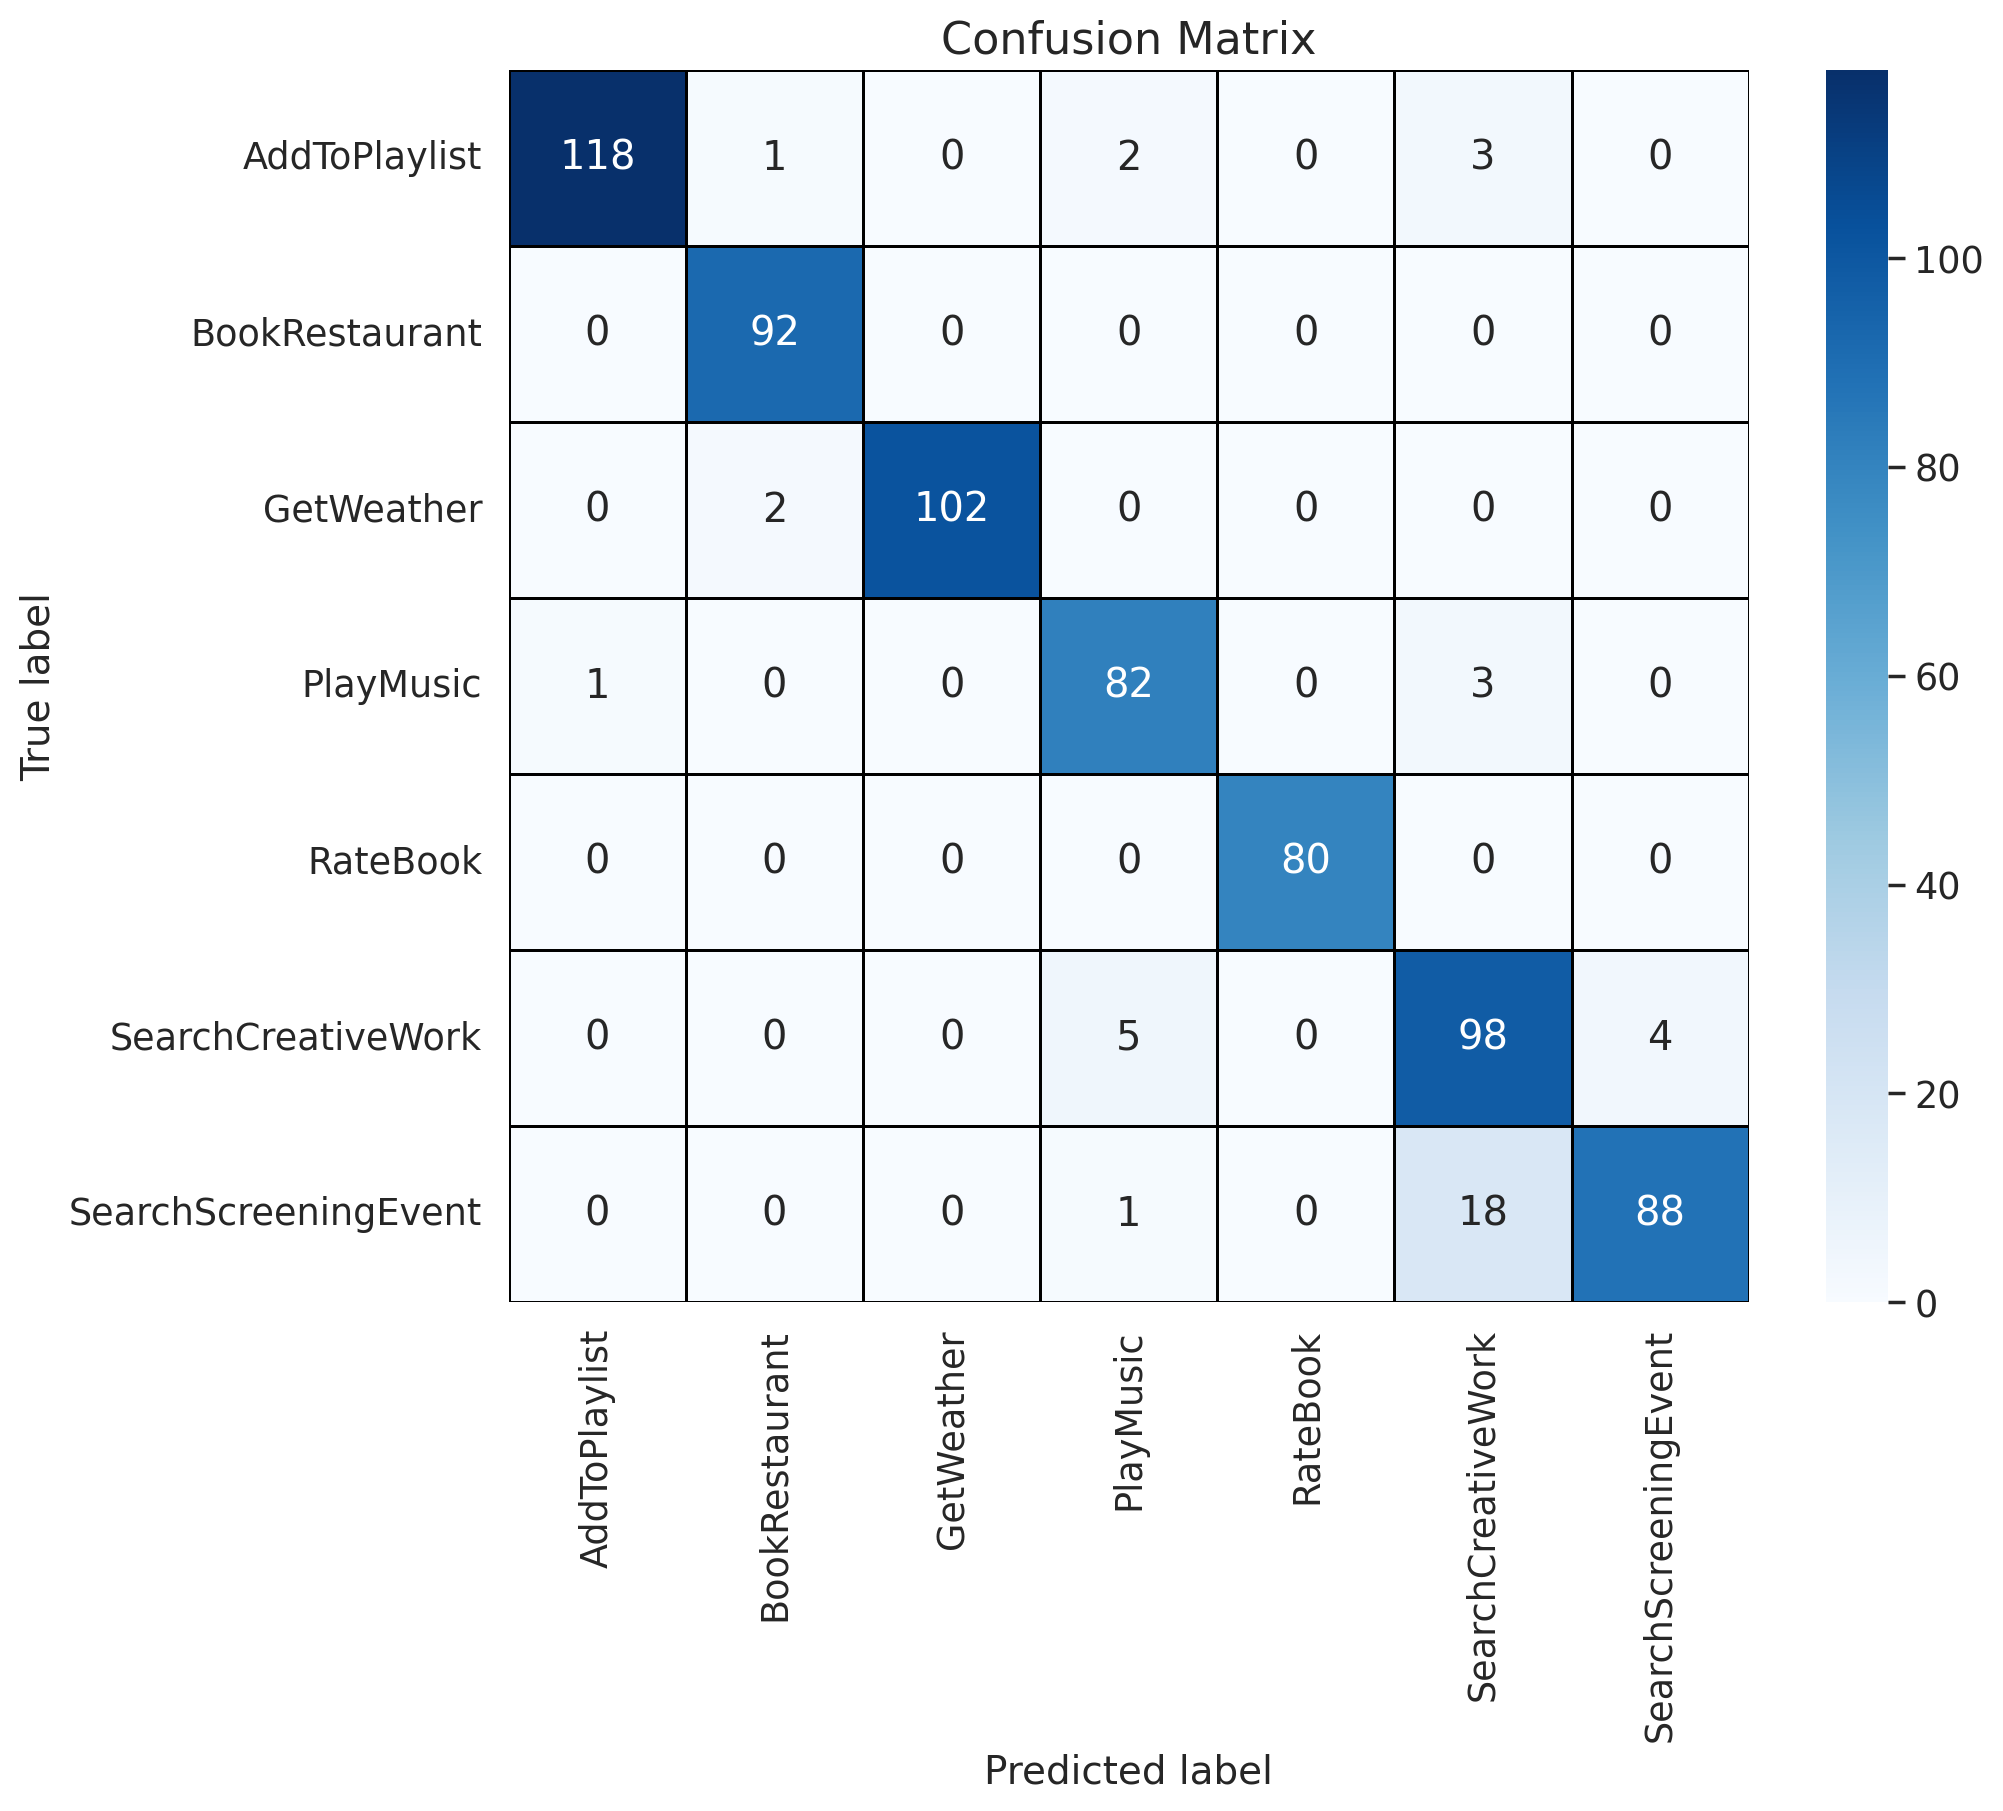

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

y_pred_prob = model.predict([test_input_ids, test_attention_mask])  
y_pred = np.argmax(y_pred_prob, axis=1)  

cm = confusion_matrix(data.test_y, y_pred)

print("Matrice de confusion :\n", cm)

df_cm = pd.DataFrame(cm, index=classes, columns=classes)

if df_cm.isnull().values.any():
    print("La matrice de confusion contient des valeurs nulles.")

plt.figure(figsize=(10, 8)) 
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=True, linewidths=.5, linecolor='black')  # Modifier la palette de couleurs

plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)  

plt.show() 


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

test_report = classification_report(data.test_y, test_y_pred, output_dict=True)
accuracy = test_report['accuracy']

macro_avg = test_report['macro avg']
weighted_avg = test_report['weighted avg']

summary_df = pd.DataFrame({
    'precision': [macro_avg['precision'], weighted_avg['precision']],
    'recall': [macro_avg['recall'], weighted_avg['recall']],
    'f1-score': [macro_avg['f1-score'], weighted_avg['f1-score']],
    'support': [macro_avg['support'], weighted_avg['support']],
    
}, index=['Macro Avg', 'Weighted Avg'])

print("Résumé des performances du modèle sur l'ensemble de test :\n")
print(summary_df)
print(f"L'accuracy est : {accuracy:.2f}")


Résumé des performances du modèle sur l'ensemble de test :

              precision    recall  f1-score  support
Macro Avg      0.947276  0.946313  0.945368      700
Weighted Avg   0.946724  0.942857  0.943275      700
L'accuracy est : 0.94
